In [27]:
import tensorflow as tf
import keras as k

from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from keras import backend
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random as r
import numpy as np

if tf.test.gpu_device_name():
    print('GPU avaliable {}'.format(tf.test.gpu_device_name()))
else:
    print('Please install GPU version of TF')
    
print(tf.version.VERSION)


GPU avaliable /device:GPU:0
2.5.0


In [28]:
HEIGHT = 299
WIDTH = 187
BATCH_SIZE = 16
PATH_TRAIN = 'C:/Users/crims/Tensorflow/PublisherIdetification/publishers'
#PATH_TEST = 'C:/Users/crims/Tensorflow/PublisherIdetification/publishers'

train_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255)
                                     
train_data = train_generator.flow_from_directory(PATH_TRAIN, target_size=(HEIGHT, WIDTH),
                                                 class_mode = 'categorical', batch_size=BATCH_SIZE, 
                                                 subset = 'training')

valid_data = train_generator.flow_from_directory(PATH_TRAIN, target_size=(HEIGHT, WIDTH),
                                                 class_mode = 'categorical', batch_size=BATCH_SIZE, 
                                                 subset = 'validation')

#test_data = test_generator.flow_from_directory(PATH_TEST, target_size=(HEIGHT, WIDTH), 
#                                                class_mode=None, batch_size=1, 
#                                                shuffle=False)

Found 1993 images belonging to 6 classes.
Found 496 images belonging to 6 classes.


In [29]:
base = Xception(include_top=False, weights='imagenet', input_shape=(HEIGHT, WIDTH, 3), pooling='avg')
x = base.output
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(6, activation='softmax')(x)
xception = Model(base.input, x)
xception.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='RMSprop')

xception.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 187, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 93, 32)  864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 93, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 93, 32)  0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [32]:
#Train model
history = xception.fit(train_data, validation_data=valid_data, epochs=50, 
                       steps_per_epoch=100, validation_steps=20, batch_size=BATCH_SIZE)

xception.save('xception_publisherid')

Epoch 1/50
100/100 [==============================] - 31s 311ms/step - loss: 0.2593 - acc: 0.9102 - val_loss: 2.4340 - val_acc: 0.5063
Epoch 2/50
100/100 [==============================] - 31s 311ms/step - loss: 0.2675 - acc: 0.9169 - val_loss: 3.2429 - val_acc: 0.4844
Epoch 3/50
100/100 [==============================] - 31s 312ms/step - loss: 0.2281 - acc: 0.9272 - val_loss: 2.4023 - val_acc: 0.4938
Epoch 4/50
100/100 [==============================] - 31s 311ms/step - loss: 0.1966 - acc: 0.9284 - val_loss: 5.3504 - val_acc: 0.4812
Epoch 5/50
100/100 [==============================] - 31s 312ms/step - loss: 0.1843 - acc: 0.9353 - val_loss: 3.8123 - val_acc: 0.5562
Epoch 6/50
100/100 [==============================] - 32s 319ms/step - loss: 0.1957 - acc: 0.9360 - val_loss: 5.3713 - val_acc: 0.5219
Epoch 7/50
100/100 [==============================] - 32s 321ms/step - loss: 0.1804 - acc: 0.9416 - val_loss: 5.2854 - val_acc: 0.4656
Epoch 8/50
100/100 [==============================] - 3

C:\Users\crims\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: xception_publisherid\assets


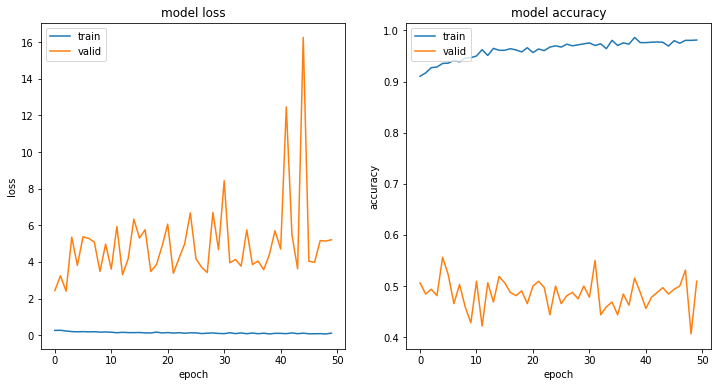

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()